In [31]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Z-axis & Discretization

In [2]:
# Number of Spatial Node
#N = 26
N = 251
L = 0.2
z_dom = np.linspace(0,L,N)

# Discretization matrix d & dd
# d = ?
h_arr = (z_dom[1]-z_dom[0])*np.ones([N,])
d_arr = 1/h_arr
#d_upp = np.diag(d_arr[:-1],1)
d_mid = np.diag(d_arr,0)
d_low = np.diag(d_arr[:-1], -1)
d = d_mid - d_low
d[0,:] = 0
#print(d)

# dd = ?
dd_arr = 1/h_arr**2
dd_upp = np.diag(dd_arr[:-1],1)
dd_mid = np.diag(dd_arr,0)
dd_low = np.diag(dd_arr[:-1],-1)
dd = dd_upp -2*dd_mid + dd_low
dd[0,:] = 0
dd[-1,:] = 0
#print(dd)

# Isotherm Model

In [5]:
qm1 = 0.5
qm2 = 3

b1 = 0.01
b2 = 0.2

def iso(P1,P2): # in bar
    deno = 1 + b1*P1 + b2*P2
    nume1 = qm1*b1*P1
    nume2 = qm2*b2*P2
    q1 = nume1/deno
    q2 = nume2/deno
    return q1,q2
    
    

# Initial value

In [22]:
P_init = 1E5*np.ones(N)
T_init = 300
R_gas = 8.3145
C1_init = 1*P_init/R_gas/T_init*np.ones(N)
C2_init = 0*P_init/R_gas/T_init*np.ones(N)
q1_init,q2_init = iso(1*P_init, 0*P_init)
y0 = np.concatenate([C1_init,C2_init, q1_init, q2_init])

# Boundary conditions
P_feed = 1E5
C1_feed = 0.5*P_feed/R_gas/T_init
C2_feed = 0.5*P_feed/R_gas/T_init

# Model for Odeint

In [45]:
# Additional parameters
D_AB = 1E-6
h = h_arr[0]
#C_end = 1
T_g = T_init
# Process parameters
u_g = 0.01 # m/s : advective velocity
rho_s = 1000 # kg/m^3
epsi = 0.35 # void fraction of pellet
k1,k2 = [0.3,0.3]

# PDE -> ODE model
def model_BT(y,t):
    C1= y[:N]
    C2= y[N:2*N]
    q1 = y[2*N:3*N]
    q2 = y[3*N:4*N]
    
    # Pressure
    P1 = C1*R_gas*T_g/1E5 # in bar
    P2 = C2*R_gas*T_g/1E5 # in bar
    
    # Isotherm
    q1sta, q2sta = iso(P1,P2)
    
    # Discretization
    dC1 = d@C1
    dC2 = d@C2
    ddC1 = dd@C1
    ddC2 = dd@C2

    # LDF
    dq1dt = k1*(q1sta - q1)
    dq2dt = k2*(q2sta - q2)
    
    # Mass balance
    dC1dt = D_AB*ddC1-u_g*dC1 - rho_s*(1-epsi)/epsi*dq1dt
    dC2dt = D_AB*ddC2-u_g*dC2 - rho_s*(1-epsi)/epsi*dq2dt
    
    # Boundary conditions
    dC1dt[0] = (D_AB/h**2*C1[1] - 2*D_AB/h**2*C1[0] + D_AB/h**2*C1_feed) 
    - u_g*(C1[0]-C1_feed)/h - rho_s*(1-epsi)/epsi*dq1dt[0]
    dC2dt[0] = (D_AB/h**2*C2[1] - 2*D_AB/h**2*C2[0] + D_AB/h**2*C2_feed) 
    - u_g*(C2[0]-C2_feed)/h - rho_s*(1-epsi)/epsi*dq2dt[0]
    
    dC1dt[-1] = (D_AB/h**2*C1[-2] - 2*D_AB/h**2*C1[-1] + D_AB/h**2*C1[-2]) 
    - u_g*(C1[-1]-C1[-2])/h - rho_s*(1-epsi)/epsi*dq1dt[-1]
    dC2dt[-1] = (D_AB/h**2*C2[-2] - 2*D_AB/h**2*C2[-1] + D_AB/h**2*C2[-2]) 
    - u_g*(C2[-1]-C2[-2])/h - rho_s*(1-epsi)/epsi*dq2dt[-1]
    dydt = np.concatenate([dC1dt,dC2dt, dq1dt,dq2dt])
    return dydt

In [46]:
# Time domain
t_ran = np.arange(0,300+0.1,0.1)
#print(C0.shape)
y_res = odeint(model_BT, y0, t_ran)
print(y_res.shape)

(3001, 1004)


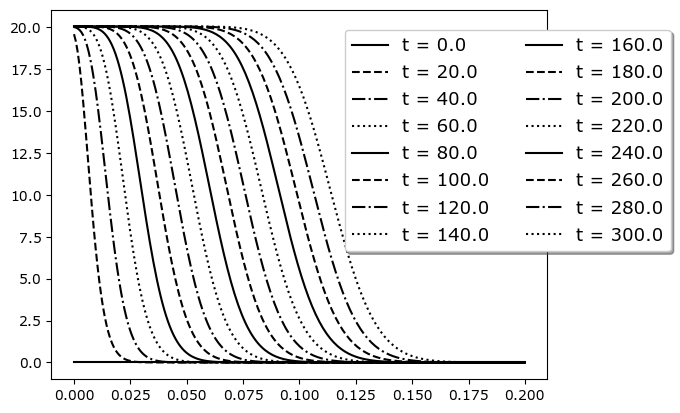

In [47]:
t_sample = t_ran[::200]
ii_ran = np.arange(len(t_ran))[::200]
#print(ii_ran)

ls_list = ['-','--','-.',':']
cc = 0
for ii, tt in zip(ii_ran, t_sample):
    C_samp = y_res[ii, N:2*N]
    plt.plot(z_dom, C_samp, 'k',
             linestyle = ls_list[cc%len(ls_list)],
             label = f't = {tt}')
    cc +=1
    
plt.legend(fontsize = 13, fancybox = True, shadow = True, ncol=2,
          loc = 'upper center', bbox_to_anchor=(0.92,0.97))
